In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
from utils import inverse_logit_transform, prepare_transformed_dataset

In [2]:
train_data, test_data = prepare_transformed_dataset()
train_data.drop(columns=['sorter_id'], inplace=True)
test_data.drop(columns=['sorter_id'], inplace=True)

Loaded from cache


/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/tables/array.py:241: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (oid, self.atom, self.shape, self._v_chunkshape) = self._open_array()
/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())
/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [3]:
X_train = train_data.drop(columns='agreement_score')
y_train = train_data['agreement_score']
X_test = test_data.drop(columns='agreement_score')
y_test = test_data['agreement_score']

In [4]:
# Model with parameters unchanged

model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [5]:
y_preds = model.predict(X_test)

In [6]:
rescaled_y_preds = inverse_logit_transform(y_preds)
rescaled_y_test = inverse_logit_transform(y_test)

In [7]:
rmse = np.sqrt(mean_squared_error(rescaled_y_preds, rescaled_y_test))
print(rmse)

0.2762987765459454


/home/mclancy/.local/share/.pyenv/versions/3.8.3/envs/truespikes/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='agreement_score'>

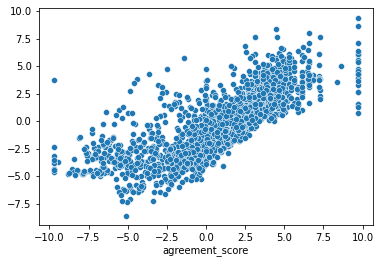

In [8]:
sns.scatterplot(y_test, y_preds)

<AxesSubplot:ylabel='Count'>

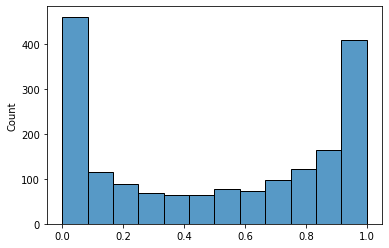

In [9]:
sns.histplot(rescaled_y_preds)

<AxesSubplot:xlabel='agreement_score', ylabel='Count'>

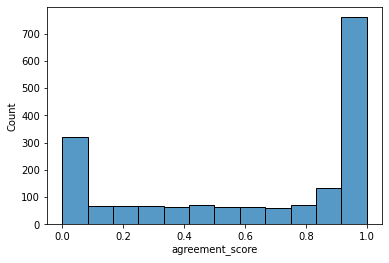

In [10]:
sns.histplot(rescaled_y_test)

In [11]:
fp_preds = rescaled_y_preds >= 0.5
fp_test = rescaled_y_test >= 0.5

f1_score(fp_preds, fp_test)

0.8358778625954199